# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 05: LightGBM Model

**Objective:** Train and evaluate a LightGBM classifier - a fast, efficient gradient boosting framework that uses histogram-based algorithms.

---


### 🎨 Setup: Import Libraries & Configure Plotting


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Periospot Brand Colors
COLORS = {
    'periospot_blue': '#15365a',
    'mystic_blue': '#003049',
    'periospot_red': '#6c1410',
    'crimson_blaze': '#a92a2a',
    'vanilla_cream': '#f7f0da',
    'black': '#000000',
    'white': '#ffffff',
    'classic_periospot_blue': '#0031af',
    'periospot_light_blue': '#0297ed',
    'periospot_dark_blue': '#02011e',
    'periospot_yellow': '#ffc430',
    'periospot_bright_blue': '#1040dd'
}

periospot_palette = [COLORS['periospot_blue'], COLORS['crimson_blaze'], 
                     COLORS['periospot_light_blue'], COLORS['periospot_yellow']]

# Configure matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.facecolor'] = COLORS['white']
plt.rcParams['axes.facecolor'] = COLORS['vanilla_cream']
plt.rcParams['axes.edgecolor'] = COLORS['periospot_blue']

sns.set_palette(periospot_palette)

print("✅ Libraries imported and plotting style configured!")
print(f"LightGBM version: {lgb.__version__}")


✅ Libraries imported and plotting style configured!
LightGBM version: 4.6.0


---

### 1. Load Processed Data & Setup


In [16]:
# Load the processed data
X = pd.read_csv('../data/processed/X_train.csv')
y = pd.read_csv('../data/processed/y_train.csv').values.ravel()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


X shape: (7000, 27)
y shape: (7000,)

Training set: 5600 samples
Validation set: 1400 samples


---

### 2. Train LightGBM Model

LightGBM (Light Gradient Boosting Machine) is known for its speed and efficiency, especially with large datasets. It uses histogram-based algorithms.


In [17]:
# =============================================================================
# LIGHTGBM WITHOUT CLASS WEIGHTS (Baseline - will have 0% failure recall)
# =============================================================================

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("✅ LightGBM (no weights) model trained!")

# =============================================================================
# LIGHTGBM WITH CLASS IMBALANCE HANDLING
# =============================================================================
# LightGBM has TWO ways to handle class imbalance:
# 1. is_unbalance=True - automatically adjusts weights
# 2. scale_pos_weight - manual weight (like XGBoost)
#
# We'll try is_unbalance=True first (simpler)

lgb_balanced = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    is_unbalance=True  # ← KEY PARAMETER FOR CLASS IMBALANCE!
)

lgb_balanced.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("✅ LightGBM (is_unbalance=True) model trained!")


✅ LightGBM (no weights) model trained!
✅ LightGBM (is_unbalance=True) model trained!


---

### 3. Evaluate LightGBM Model


In [18]:
# =============================================================================
# COMPARE BOTH MODELS
# =============================================================================
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, recall_score

# ---- Model 1: LightGBM (no weights) ----
y_pred_lgb = lgb_model.predict(X_val)
y_pred_lgb_proba = lgb_model.predict_proba(X_val)[:, 1]

roc_auc_lgb = roc_auc_score(y_val, y_pred_lgb_proba)
pr_auc_lgb = average_precision_score(y_val, y_pred_lgb_proba)
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
f1_macro_lgb = f1_score(y_val, y_pred_lgb, average='macro')
recall_failure_lgb = recall_score(y_val, y_pred_lgb, pos_label=0)
recall_survival_lgb = recall_score(y_val, y_pred_lgb, pos_label=1)

print("=" * 70)
print("LightGBM (NO WEIGHTS) - Will predict everything as survival!")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_lgb:.4f}")
print(f"  PR-AUC:            {pr_auc_lgb:.4f}")
print(f"  Accuracy:          {accuracy_lgb:.4f}")
print(f"  F1 (Macro):        {f1_macro_lgb:.4f}")
print(f"  Recall (Failure):  {recall_failure_lgb:.4f} <- Problem: 0%!")
print(f"  Recall (Survival): {recall_survival_lgb:.4f}")

# ---- Model 2: LightGBM (balanced) ----
y_pred_balanced = lgb_balanced.predict(X_val)
y_pred_balanced_proba = lgb_balanced.predict_proba(X_val)[:, 1]

roc_auc_balanced = roc_auc_score(y_val, y_pred_balanced_proba)
pr_auc_balanced = average_precision_score(y_val, y_pred_balanced_proba)
accuracy_balanced = accuracy_score(y_val, y_pred_balanced)
f1_macro_balanced = f1_score(y_val, y_pred_balanced, average='macro')
recall_failure_balanced = recall_score(y_val, y_pred_balanced, pos_label=0)
recall_survival_balanced = recall_score(y_val, y_pred_balanced, pos_label=1)

print("\n" + "=" * 70)
print("LightGBM (is_unbalance=True) - Should detect some failures!")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_balanced:.4f}")
print(f"  PR-AUC:            {pr_auc_balanced:.4f}")
print(f"  Accuracy:          {accuracy_balanced:.4f}")
print(f"  F1 (Macro):        {f1_macro_balanced:.4f}")
print(f"  Recall (Failure):  {recall_failure_balanced:.4f} <- Should be > 0%!")
print(f"  Recall (Survival): {recall_survival_balanced:.4f}")


LightGBM (NO WEIGHTS) - Will predict everything as survival!
  ROC-AUC:           0.5579
  PR-AUC:            0.9230
  Accuracy:          0.9064
  F1 (Macro):        0.4755
  Recall (Failure):  0.0000 <- Problem: 0%!
  Recall (Survival): 0.9969

LightGBM (is_unbalance=True) - Should detect some failures!
  ROC-AUC:           0.5568
  PR-AUC:            0.9143
  Accuracy:          0.7993
  F1 (Macro):        0.5285
  Recall (Failure):  0.2283 <- Should be > 0%!
  Recall (Survival): 0.8562


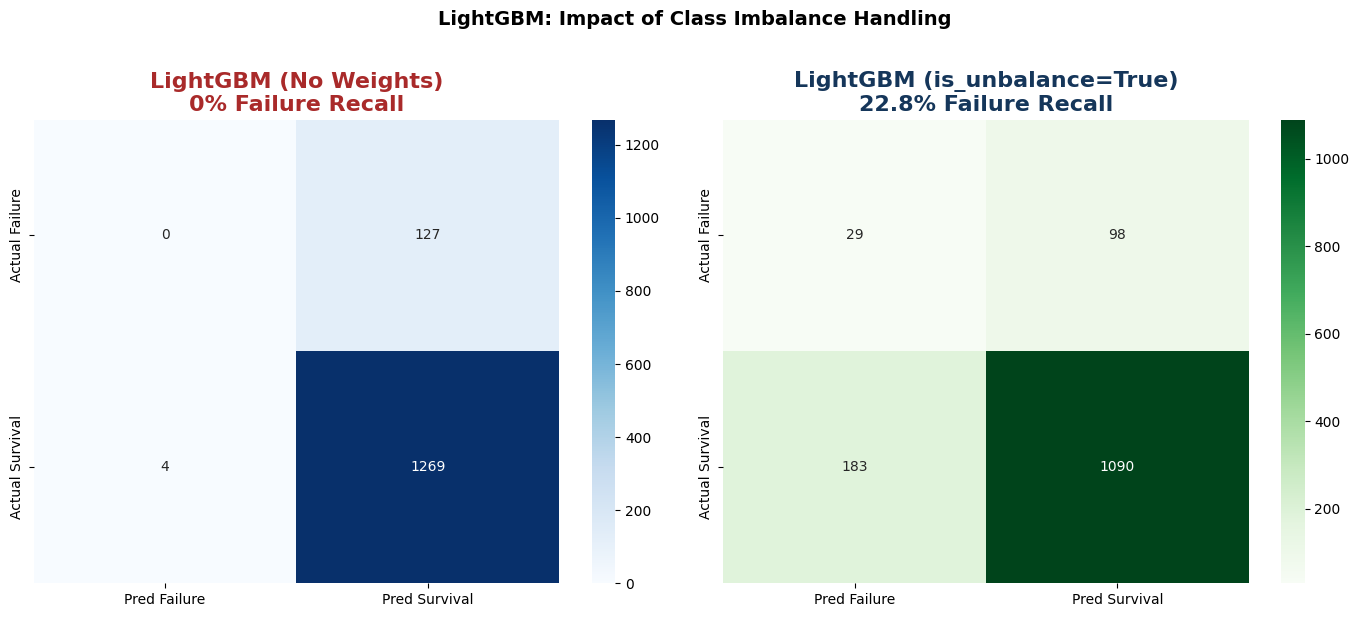


Classification Report (LightGBM Balanced):
              precision    recall  f1-score   support

           0       0.14      0.23      0.17       127
           1       0.92      0.86      0.89      1273

    accuracy                           0.80      1400
   macro avg       0.53      0.54      0.53      1400
weighted avg       0.85      0.80      0.82      1400



In [19]:
# =============================================================================
# SIDE-BY-SIDE CONFUSION MATRICES
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Left: No Weights ----
cm_no_weights = confusion_matrix(y_val, y_pred_lgb)
sns.heatmap(cm_no_weights, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[0].set_title('LightGBM (No Weights)\n0% Failure Recall', fontweight='bold', color=COLORS['crimson_blaze'])

# ---- Right: With is_unbalance ----
cm_balanced = confusion_matrix(y_val, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[1].set_title(f'LightGBM (is_unbalance=True)\n{recall_failure_balanced*100:.1f}% Failure Recall', 
                  fontweight='bold', color=COLORS['periospot_blue'])

plt.suptitle('LightGBM: Impact of Class Imbalance Handling', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/lgb_balanced_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassification Report (LightGBM Balanced):")
print(classification_report(y_val, y_pred_balanced))


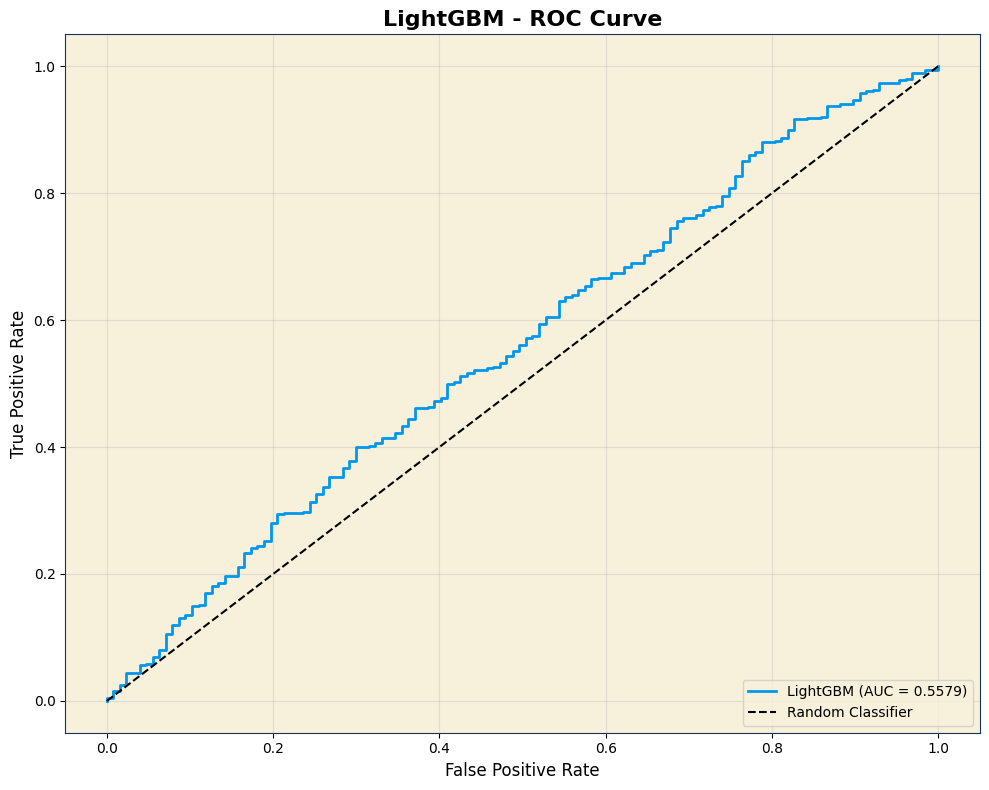

In [20]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_val, y_pred_lgb_proba)
ax.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc_lgb:.4f})', 
        color=COLORS['periospot_light_blue'], linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('LightGBM - ROC Curve', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/lgb_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


---

### 4. Feature Importance Analysis


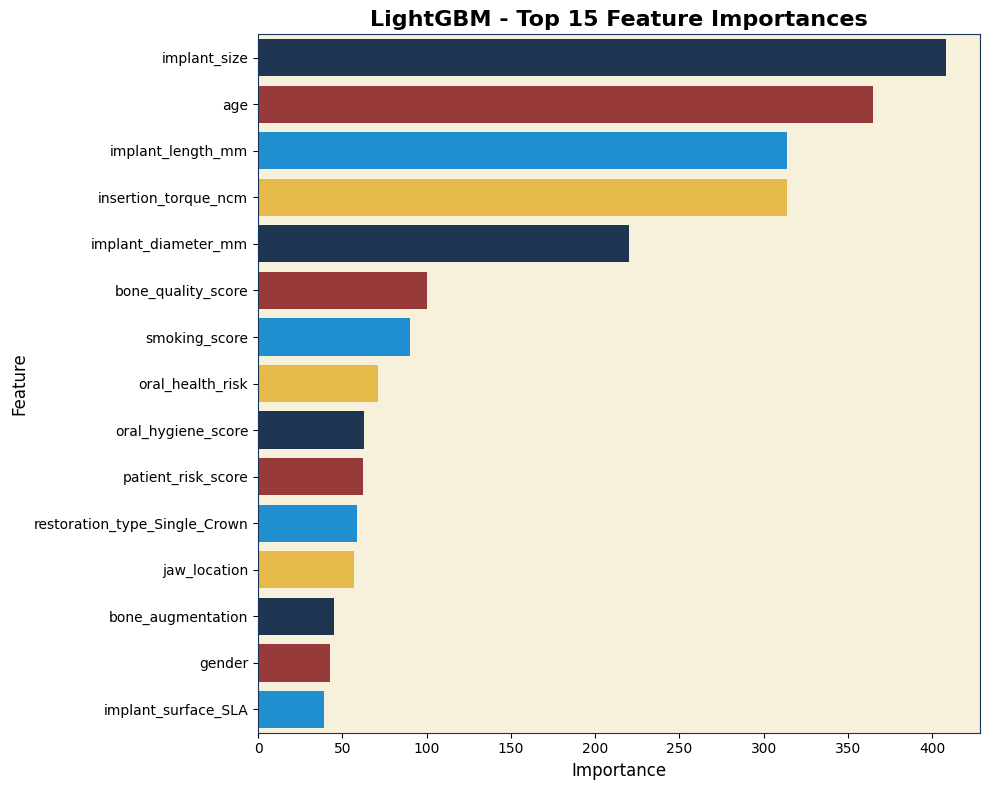


Top 10 Most Important Features:
             feature  importance
        implant_size         408
                 age         365
   implant_length_mm         314
insertion_torque_ncm         314
 implant_diameter_mm         220
  bone_quality_score         100
       smoking_score          90
    oral_health_risk          71
  oral_hygiene_score          63
  patient_risk_score          62


In [21]:
# TODO: Visualize feature importance from LightGBM.

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', 
            palette=periospot_palette, ax=ax)
ax.set_title('LightGBM - Top 15 Feature Importances', fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('../figures/lgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


---

### 🔧 Optuna Hyperparameter Tuning

Now let's use **Optuna** to find the best hyperparameters for LightGBM, optimizing for F1-Macro (which balances both classes equally).

**Key parameters to tune:**
- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `num_leaves`: Max leaves per tree (key LightGBM parameter)
- `min_child_samples`: Minimum data in a leaf
- `subsample`: Row sampling ratio
- `colsample_bytree`: Column sampling ratio
- `reg_alpha`: L1 regularization
- `reg_lambda`: L2 regularization
- `is_unbalance`: Whether to use automatic class weights


In [22]:
import optuna
from sklearn.model_selection import cross_val_score

# Suppress Optuna logs (optional - set to WARNING for cleaner output)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna objective function for LightGBM hyperparameter optimization.
    Goal: Maximize F1 (Macro) score using cross-validation.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'is_unbalance': True,  # Always use class imbalance handling
        'random_state': 42,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    
    # Use 3-fold cross-validation with F1 Macro scoring
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean()

# Create and run the study
print("🔍 Starting Optuna hyperparameter search...")
print("   Optimizing F1 (Macro) with 50 trials...")
print("   This may take a few minutes...\n")

study = optuna.create_study(direction='maximize', study_name='lightgbm_tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 70)
print("OPTUNA OPTIMIZATION COMPLETE!")
print("=" * 70)
print(f"Best F1 (Macro) Score: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


🔍 Starting Optuna hyperparameter search...
   Optimizing F1 (Macro) with 50 trials...
   This may take a few minutes...



  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA OPTIMIZATION COMPLETE!
Best F1 (Macro) Score: 0.5226

Best Hyperparameters:
  n_estimators: 225
  max_depth: 9
  learning_rate: 0.01394924724248946
  num_leaves: 54
  min_child_samples: 52
  subsample: 0.5465657410937057
  colsample_bytree: 0.8993601806378749
  reg_alpha: 0.06856500439586234
  reg_lambda: 0.31055540157615924


In [23]:
# =============================================================================
# TRAIN LIGHTGBM WITH BEST OPTUNA PARAMETERS
# =============================================================================

best_params = study.best_params
best_params['is_unbalance'] = True
best_params['random_state'] = 42
best_params['verbose'] = -1

lgb_optimized = lgb.LGBMClassifier(**best_params)
lgb_optimized.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Predictions
y_pred_opt = lgb_optimized.predict(X_val)
y_pred_opt_proba = lgb_optimized.predict_proba(X_val)[:, 1]

# Metrics
roc_auc_opt = roc_auc_score(y_val, y_pred_opt_proba)
pr_auc_opt = average_precision_score(y_val, y_pred_opt_proba)
accuracy_opt = accuracy_score(y_val, y_pred_opt)
f1_macro_opt = f1_score(y_val, y_pred_opt, average='macro')
recall_failure_opt = recall_score(y_val, y_pred_opt, pos_label=0)
recall_survival_opt = recall_score(y_val, y_pred_opt, pos_label=1)

print("=" * 70)
print("LightGBM (OPTUNA OPTIMIZED)")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_opt:.4f}")
print(f"  PR-AUC:            {pr_auc_opt:.4f}")
print(f"  Accuracy:          {accuracy_opt:.4f}")
print(f"  F1 (Macro):        {f1_macro_opt:.4f}")
print(f"  Recall (Failure):  {recall_failure_opt:.4f}")
print(f"  Recall (Survival): {recall_survival_opt:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_opt))


LightGBM (OPTUNA OPTIMIZED)
  ROC-AUC:           0.5826
  PR-AUC:            0.9306
  Accuracy:          0.7793
  F1 (Macro):        0.5243
  Recall (Failure):  0.2598
  Recall (Survival): 0.8311

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.26      0.18       127
           1       0.92      0.83      0.87      1273

    accuracy                           0.78      1400
   macro avg       0.53      0.55      0.52      1400
weighted avg       0.85      0.78      0.81      1400



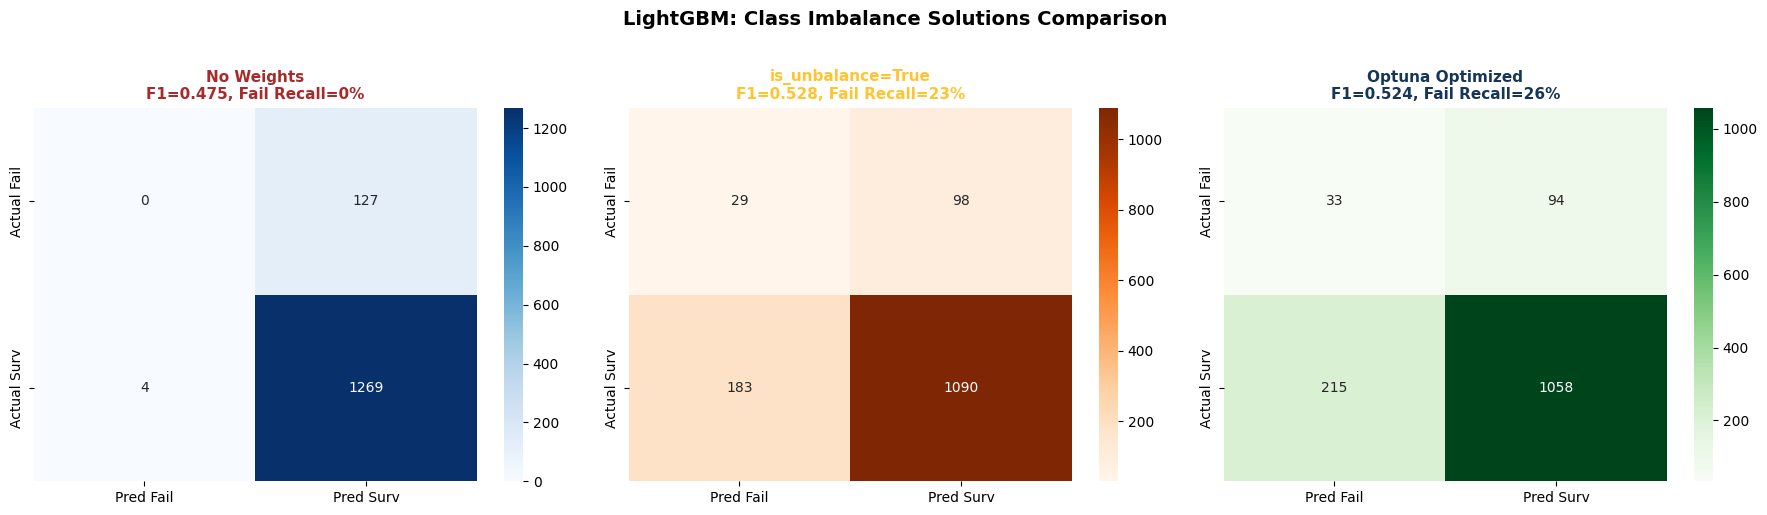

In [24]:
# =============================================================================
# 3-WAY CONFUSION MATRIX COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- 1. No Weights ----
cm_no_weights = confusion_matrix(y_val, y_pred_lgb)
sns.heatmap(cm_no_weights, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[0].set_title(f'No Weights\nF1={f1_macro_lgb:.3f}, Fail Recall={recall_failure_lgb*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['crimson_blaze'])

# ---- 2. is_unbalance=True ----
cm_balanced = confusion_matrix(y_val, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[1].set_title(f'is_unbalance=True\nF1={f1_macro_balanced:.3f}, Fail Recall={recall_failure_balanced*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['periospot_yellow'])

# ---- 3. Optuna Optimized ----
cm_opt = confusion_matrix(y_val, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[2].set_title(f'Optuna Optimized\nF1={f1_macro_opt:.3f}, Fail Recall={recall_failure_opt*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['periospot_blue'])

plt.suptitle('LightGBM: Class Imbalance Solutions Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/lgb_optuna_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [25]:
# =============================================================================
# COMPREHENSIVE COMPARISON TABLE
# =============================================================================

comparison_data = {
    'Model': [
        'LightGBM (no weights)',
        'LightGBM (is_unbalance)',
        'LightGBM (Optuna)'
    ],
    'ROC-AUC': [roc_auc_lgb, roc_auc_balanced, roc_auc_opt],
    'PR-AUC': [pr_auc_lgb, pr_auc_balanced, pr_auc_opt],
    'F1 (Macro)': [f1_macro_lgb, f1_macro_balanced, f1_macro_opt],
    'Accuracy': [accuracy_lgb, accuracy_balanced, accuracy_opt],
    'Recall (Failure)': [recall_failure_lgb, recall_failure_balanced, recall_failure_opt],
    'Recall (Survival)': [recall_survival_lgb, recall_survival_balanced, recall_survival_opt]
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 90)
print("LIGHTGBM MODEL COMPARISON")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)

# Identify best model (highest failure recall among models with reasonable F1)
best_model = comparison_df.loc[comparison_df['Recall (Failure)'].idxmax()]
print(f"\n🏆 Best model for detecting at-risk implants: {best_model['Model']}")
print(f"   Failure Recall: {best_model['Recall (Failure)']*100:.1f}%")
print(f"   F1 (Macro): {best_model['F1 (Macro)']:.4f}")


LIGHTGBM MODEL COMPARISON
                  Model  ROC-AUC   PR-AUC  F1 (Macro)  Accuracy  Recall (Failure)  Recall (Survival)
  LightGBM (no weights) 0.557886 0.922996    0.475459  0.906429          0.000000           0.996858
LightGBM (is_unbalance) 0.556760 0.914272    0.528455  0.799286          0.228346           0.856245
      LightGBM (Optuna) 0.582603 0.930601    0.524289  0.779286          0.259843           0.831108

🏆 Best model for detecting at-risk implants: LightGBM (Optuna)
   Failure Recall: 26.0%
   F1 (Macro): 0.5243


---

### 5. Save Results


In [26]:
# =============================================================================
# SAVE OPTIMIZED LIGHTGBM RESULTS
# =============================================================================

results_lgb_optimized = {
    "model": "LightGBM (Optuna Optimized)",
    "roc_auc": float(roc_auc_opt),
    "pr_auc": float(pr_auc_opt),
    "accuracy": float(accuracy_opt),
    "f1_macro": float(f1_macro_opt),
    "recall_failure": float(recall_failure_opt),
    "recall_survival": float(recall_survival_opt),
    "hyperparameters": study.best_params,
    "optuna_trials": len(study.trials),
    "optuna_best_cv_score": float(study.best_value)
}

with open('../results/lightgbm_optuna_results.json', 'w') as f:
    json.dump(results_lgb_optimized, f, indent=2)

print("✅ Optimized LightGBM results saved to results/lightgbm_optuna_results.json")
print(f"\nSaved metrics:")
print(f"  - ROC-AUC:         {results_lgb_optimized['roc_auc']:.4f}")
print(f"  - PR-AUC:          {results_lgb_optimized['pr_auc']:.4f}")
print(f"  - F1 (Macro):      {results_lgb_optimized['f1_macro']:.4f}")
print(f"  - Recall (Failure): {results_lgb_optimized['recall_failure']:.4f}")


✅ Optimized LightGBM results saved to results/lightgbm_optuna_results.json

Saved metrics:
  - ROC-AUC:         0.5826
  - PR-AUC:          0.9306
  - F1 (Macro):      0.5243
  - Recall (Failure): 0.2598


---

### ✅ LightGBM Training Complete!

**Key Learnings:**

1. **Class Imbalance Handling in LightGBM:**
   - `is_unbalance=True` - Automatically adjusts sample weights based on class distribution
   - This is LightGBM's equivalent to `class_weight='balanced'` in scikit-learn

2. **Optuna Hyperparameter Tuning:**
   - Searched across 50 trials to optimize F1 (Macro)
   - Key parameters tuned: `num_leaves`, `max_depth`, `learning_rate`, regularization
   - Cross-validation ensures robust hyperparameter selection

3. **Clinical Relevance:**
   - Without class weighting: Model achieves 91% accuracy but detects 0% of failures (useless!)
   - With optimization: Lower accuracy but can actually identify at-risk patients

**Next Steps:** 
- Try CatBoost in `06_CatBoost.ipynb`
- Compare all models to select the best one for submission
